# Catboost Baseline

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv
/kaggle/input/predict-student-performance-from-game-play/train_labels.csv
/kaggle/input/predict-student-performance-from-game-play/train.csv
/kaggle/input/predict-student-performance-from-game-play/test.csv
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder_310/__init__.py
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/predict-student-performance-from-game-play/jo_wilder/__init__.py


In [2]:
import polars as pl
import gc
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math
from time import sleep
import pickle
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading Files

In [3]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))

In [4]:
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ) ,
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")

]

In [5]:
dtypes = {"session_id": pl.Int64,
          "elapsed_time": pl.Int64,
          "event_name": pl.Categorical,
          "name": pl.Categorical,
          "level": pl.Int8,
          "page": pl.Float32,
          "room_coor_x": pl.Float32,
          "room_coor_y": pl.Float32,
          "screen_coor_x": pl.Float32,
          "screen_coor_y": pl.Float32,
          "hover_duration": pl.Float32,
          "fqid": pl.Categorical,
          "room_fqid": pl.Categorical,
          "fullscreen": pl.Int8,
          "hq": pl.Int8,
          "music": pl.Int8,
          "level_group": pl.Categorical
          }

In [6]:
pl.toggle_string_cache(True)

In [7]:
%%time

train = (pl.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',dtypes=dtypes)
                .drop(["fullscreen", "hq", "music"])
                .with_columns(columns)
        )

CPU times: user 48.5 s, sys: 19.9 s, total: 1min 8s
Wall time: 58 s


# Reducing training file

In [8]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df

In [9]:
# Reducing polar
train = reduce_memory_usage_pl(train, "train_subset")

Memory usage of dataframe train_subset is 3264.77 MB
Memory usage of dataframe train_subset became 1802.58 MB


In [10]:
df1 = train.filter(pl.col("level_group")=='0-4')
df2 = train.filter(pl.col("level_group")=='5-12')
df3 = train.filter(pl.col("level_group")=='13-22')
df1.shape,df2.shape,df3.shape

((3981005, 18), (8844238, 18), (13471703, 18))

In [11]:
df3.head(8)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group,elapsed_time_diff
i64,i16,i32,cat,cat,i8,f32,f32,f32,f32,f32,f32,cat,cat,cat,cat,cat,i32
20090312431273200,512,836732,"""navigate_click…","""undefined""",13,null,290.153564,-204.499359,null,null,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",0
20090312431273200,513,837245,"""navigate_click…","""undefined""",13,null,353.805603,-210.332062,21.0,0.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",513
20090312431273200,514,837779,"""navigate_click…","""undefined""",13,null,587.680054,-280.706238,108.0,44.0,null,null,"""fqid_None""","""tunic.capitol_…","""text_fqid_None…","""13-22""",534
20090312431273200,515,838446,"""navigate_click…","""undefined""",13,null,751.496887,-102.15329,43.0,124.0,null,null,"""toentry""","""tunic.capitol_…","""text_fqid_None…","""13-22""",667
20090312431273200,516,839629,"""map_hover""","""basic""",13,null,null,null,null,null,67.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1183
20090312431273200,517,840662,"""map_hover""","""basic""",13,null,null,null,null,null,983.0,null,"""tunic.dryclean…","""tunic.capitol_…","""text_fqid_None…","""13-22""",1033
20090312431273200,518,840780,"""map_hover""","""basic""",13,null,null,null,null,null,100.0,null,"""tunic.historic…","""tunic.capitol_…","""text_fqid_None…","""13-22""",118
20090312431273200,519,840830,"""map_hover""","""basic""",13,null,null,null,null,null,35.0,null,"""tunic.capitol_…","""tunic.capitol_…","""text_fqid_None…","""13-22""",50


In [12]:
#Delete train to liberate memory
del train
gc.collect()

30

# Feature Engineering

In [13]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']

fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']

text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [14]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")
                                              |(pl.col("fqid")=='logbook.page.bingo'))
                    .apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                                pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                                pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                                pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                                pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [15]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')

CPU times: user 12.3 s, sys: 854 ms, total: 13.2 s
Wall time: 6.9 s


In [16]:
%%time
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')

CPU times: user 30.5 s, sys: 1.11 s, total: 31.6 s
Wall time: 16.8 s


In [17]:
%%time
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')

CPU times: user 49.7 s, sys: 1.33 s, total: 51 s
Wall time: 26.6 s


In [18]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [19]:
df1.shape

(23562, 2344)

In [20]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    
    return train

In [21]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [22]:
df1.head(8)

session_id  session_number_  event_name_unique_  name_unique_  \
0  20090312431273200              165                  10             3   
1  20090312433251036              139                  11             4   
2  20090312455206810              149                   9             3   
3  20090313091715820              176                  11             4   
4  20090313571836404              112                  10             4   
5  20090314035813970              154                  11             4   
6  20090314121766812              165                  11             4   
7  20090314221187252              210                  11             4   

   fqid_unique_  room_fqid_unique_  text_fqid_unique_  page_std_  \
0            31                  7                 18        NaN   
1            23                  6                 12   0.000000   
2            23                  6                 13        NaN   
3            25                  6                 15   0.000000   
4            23                  6                 13   0.000000   
5            27                  6                 20   0.000000   
6            27                  7                 16   0.483046   
7            24                  6                 15   0.000000   

   room_coor_x_std_  room_coor_y_std_  screen_coor_x_std_  screen_coor_y_std_  \
0        399.296051        129.292404          144.538300           93.921089   
1        445.980042        156.186249          174.552185          111.039917   
2        478.652405        161.438385          236.266586          100.641541   
3        422.766418        161.696457          149.743561          138.407562   
4        452.898682        176.604691          228.544296          142.292816   
5        431.772400        209.019714          212.829010          143.533585   
6        418.706665        183.290268          206.542511          140.145752   
7        450.837097        157.648315          172.408798          103.397209   

   hover_duration_std_  elapsed_time_diff_std_  page_mean_  room_coor_x_mean_  \
0          3227.370850             2450.666690         NaN           7.701280   
1          2114.876465             3481.761026         0.0         -84.045975   
2          4575.148438            17276.513933         NaN        -209.830246   
3          1949.073608             3700.196651         0.0        -111.962715   
4          1743.134277             3101.735542         0.0          -5.028425   
5          5603.987793             5166.942039         0.0          25.017109   
6          2617.938232             5393.656977         0.3         125.841293   
7          1007.462158             2681.176129         0.0         -12.076721   

   room_coor_y_mean_  screen_coor_x_mean_  screen_coor_y_mean_  \
0         -71.413757            93.482758            61.151726   
1         -53.671074            92.588234            59.815125   
2         -31.125031            82.328468            36.029198   
3         -76.698105            76.403847            68.903847   
4          -1.624749           178.258072            97.408600   
5          20.786787           186.455887           104.683823   
6         -41.298328           153.765961           114.099289   
7         -51.486679            69.539680            40.449734   

   hover_duration_mean_  elapsed_time_diff_mean_  page_min_  room_coor_x_min_  \
0           2389.500000              1159.769697        NaN      -1013.383362   
1           1378.750000              1618.474820        0.0      -1112.320557   
2           3145.666748              2423.597315        NaN      -1017.030884   
3           1917.142822              1077.125000        0.0       -995.609070   
4           1580.714233              1682.937500        0.0       -918.020691   
5           5996.500000              2681.883117        0.0       -980.660522   
6           1603.400024              2348.975758        0.0       -951.492065   
7           1311.3

In [23]:
df1.shape

(23562, 2350)

In [24]:
null1 = df1.isnull().sum().sort_values(ascending=False)/len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False)/len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False)/len(df3)

drop1 = list(null1[null1 > 0.9].index)
drop2 = list(null2[null2 > 0.9].index)
drop3 = list(null3[null3 > 0.9].index)

print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique() == 1:
        #print(col)
        drop1.append(col)
        #sleep(0.1)
for col in tqdm(df2.columns):
    if df2[col].nunique() == 1:
        #print(col)
        drop2.append(col)
        #sleep(0.1)
for col in tqdm(df3.columns):
    if df3[col].nunique() == 1:
        #print(col)
        drop3.append(col)
        #sleep(0.1)

1180 905 785


  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

In [25]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [26]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]

print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 532 922 1147 features
We will train with 23562 users info


# Optuna Parameters optimization

In [27]:
def objective(trial,X,y):
    
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
    
    cat_params = {
        "depth": trial.suggest_int("depth", 1, 9),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        'n_estimators': trial.suggest_int('n_estimators', 100, 750),
        'learning_rate': 0.05,
        "objective": "Logloss",
        'random_seed': 42,
        'verbose': 0,
        "used_ram_limit": "6gb",
        'eval_metric': 'AUC'
    }

    if cat_params["bootstrap_type"] == "Bayesian":
        cat_params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif cat_params["bootstrap_type"] == "Bernoulli":
        cat_params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        
    gbm = CatBoostClassifier(**cat_params)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=80)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    
    return accuracy

In [28]:
%%time

rf_best_params = []
studies = []

# ITERATE THRU QUESTIONS 1 THRU 18
for t in tqdm(range(1,19)): #19
        
    if t <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{t}, with{len(FEATURES)}features')
    print('#'*25)
            
    # TRAIN DATA
    train_x = df[FEATURES]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
    
    # Wrap the objective inside a lambda and call objective inside it
    func = lambda trial: objective(trial, train_x, train_y['correct'])
    #Optuna 
    study = optuna.create_study(direction="maximize")
    study.optimize(func, n_trials=10, timeout=500)
    
    print(f'*** Model: {grp}_{t}')
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    print('Best value:', study.best_value)
    
    rf_best_params.append(study.best_trial.params)
    studies.append(study)
        
print("-"*80)


  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with532features
#########################


[I 2023-06-02 05:03:51,286] A new study created in memory with name: no-name-fb63f343-33ac-404e-a346-bd80068048b3
[I 2023-06-02 05:05:02,474] Trial 0 finished with value: 0.7599377564011883 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 567, 'bagging_temperature': 4.5715015896323585}. Best is trial 0 with value: 0.7599377564011883.
[I 2023-06-02 05:05:26,796] Trial 1 finished with value: 0.7582402037063234 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 332, 'subsample': 0.457131840602613}. Best is trial 0 with value: 0.7599377564011883.
[I 2023-06-02 05:06:19,101] Trial 2 finished with value: 0.7588060546046117 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 637, 'subsample': 0.31639815812446315}. Best is trial 0 with value: 0.7599377564011883.
[I 2023-06-02 05:06:34,435] Trial 3 finished with value: 0.750035365681143 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 372}. Best is t

*** Model: 0-4_1
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 467, 'subsample': 0.3296861821783648}
Best value: 0.7638987126892064
#########################
question2, with532features
#########################


[I 2023-06-02 05:10:15,454] Trial 0 finished with value: 0.9758098740981751 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 692, 'subsample': 0.15197418067077792}. Best is trial 0 with value: 0.9758098740981751.
[I 2023-06-02 05:11:46,617] Trial 1 finished with value: 0.9782147404159004 and parameters: {'depth': 8, 'bootstrap_type': 'MVS', 'n_estimators': 724}. Best is trial 1 with value: 0.9782147404159004.
[I 2023-06-02 05:12:18,902] Trial 2 finished with value: 0.9796293676616211 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 681, 'subsample': 0.14396003533649857}. Best is trial 2 with value: 0.9796293676616211.
[I 2023-06-02 05:13:38,525] Trial 3 finished with value: 0.9797708303861933 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 392, 'bagging_temperature': 0.9126632671404977}. Best is trial 3 with value: 0.9797708303861933.
[I 2023-06-02 05:13:43,564] Trial 4 finished with value: 0.9797708303861

*** Model: 0-4_2
Number of finished trials: 10
Best trial: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 612, 'bagging_temperature': 2.5812065073351254}
Best value: 0.9803366812844816
#########################
question3, with532features
#########################


[I 2023-06-02 05:18:28,795] Trial 0 finished with value: 0.9302588767859669 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 395}. Best is trial 0 with value: 0.9302588767859669.
[I 2023-06-02 05:22:14,422] Trial 1 finished with value: 0.9316735040316877 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 641, 'bagging_temperature': 3.3594173037738506}. Best is trial 1 with value: 0.9316735040316877.
[I 2023-06-02 05:22:52,999] Trial 2 finished with value: 0.9328052058282642 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 367, 'bagging_temperature': 0.4770797388230896}. Best is trial 2 with value: 0.9328052058282642.
[I 2023-06-02 05:23:19,797] Trial 3 finished with value: 0.9339369076248408 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 322, 'bagging_temperature': 0.2688782044522531}. Best is trial 3 with value: 0.9339369076248408.
[I 2023-06-02 05:23:50,963] Trial 4 finished with value:

*** Model: 0-4_3
Number of finished trials: 9
Best trial: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 279, 'subsample': 0.437977607460037}
Best value: 0.9366246993917103
#########################
question4, with922features
#########################


[I 2023-06-02 05:26:54,570] A new study created in memory with name: no-name-a5058442-7f7c-4a8e-aaaa-0e793d0e6fd9
[I 2023-06-02 05:27:44,718] Trial 0 finished with value: 0.821615504314613 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 690, 'bagging_temperature': 5.809263894297631}. Best is trial 0 with value: 0.821615504314613.
[I 2023-06-02 05:31:48,095] Trial 1 finished with value: 0.8264252369500636 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 355, 'subsample': 0.3660750848764437}. Best is trial 1 with value: 0.8264252369500636.
[I 2023-06-02 05:32:07,359] Trial 2 finished with value: 0.8097326354505587 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 344, 'bagging_temperature': 9.357718768141728}. Best is trial 1 with value: 0.8264252369500636.
[I 2023-06-02 05:33:43,541] Trial 3 finished with value: 0.8237374451831943 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 747

*** Model: 5-12_4
Number of finished trials: 6
Best trial: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 355, 'subsample': 0.3660750848764437}
Best value: 0.8264252369500636
#########################
question5, with922features
#########################


[I 2023-06-02 05:36:37,694] Trial 0 finished with value: 0.655962653840713 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 599, 'bagging_temperature': 7.243646595537117}. Best is trial 0 with value: 0.655962653840713.
[I 2023-06-02 05:40:04,364] Trial 1 finished with value: 0.6520016975526949 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 311}. Best is trial 0 with value: 0.655962653840713.
[I 2023-06-02 05:40:25,607] Trial 2 finished with value: 0.6538407129721319 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 137}. Best is trial 0 with value: 0.655962653840713.
[I 2023-06-02 05:41:33,177] Trial 3 finished with value: 0.6619040882727402 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 516, 'subsample': 0.6231803905006152}. Best is trial 3 with value: 0.6619040882727402.
[I 2023-06-02 05:41:42,285] Trial 4 finished with value: 0.6453529494978073 and parameters: {'depth': 1, 'bootstrap_ty

*** Model: 5-12_5
Number of finished trials: 7
Best trial: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 516, 'subsample': 0.6231803905006152}
Best value: 0.6619040882727402
#########################
question6, with922features
#########################


[I 2023-06-02 05:46:32,416] Trial 0 finished with value: 0.7986985429339369 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 410}. Best is trial 0 with value: 0.7986985429339369.
[I 2023-06-02 05:47:59,919] Trial 1 finished with value: 0.7902107794596124 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 480, 'bagging_temperature': 1.215219135448472}. Best is trial 0 with value: 0.7986985429339369.
[I 2023-06-02 05:48:56,212] Trial 2 finished with value: 0.7936058848493422 and parameters: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 546, 'bagging_temperature': 7.631287066323569}. Best is trial 0 with value: 0.7986985429339369.
[I 2023-06-02 05:50:38,115] Trial 3 finished with value: 0.791201018531617 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 221, 'bagging_temperature': 3.641720422168393}. Best is trial 0 with value: 0.7986985429339369.
[I 2023-06-02 05:51:24,652] Trial 4 finished with value: 0.7

*** Model: 5-12_6
Number of finished trials: 10
Best trial: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 410}
Best value: 0.7986985429339369
#########################
question7, with922features
#########################


[I 2023-06-02 05:56:30,399] Trial 0 finished with value: 0.740557363134814 and parameters: {'depth': 8, 'bootstrap_type': 'Bernoulli', 'n_estimators': 719, 'subsample': 0.8382876971323685}. Best is trial 0 with value: 0.740557363134814.
[I 2023-06-02 05:56:38,159] Trial 1 finished with value: 0.7385768849908049 and parameters: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 151}. Best is trial 0 with value: 0.740557363134814.
[I 2023-06-02 05:59:09,345] Trial 2 finished with value: 0.7428207667279672 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 211, 'subsample': 0.15037071574936964}. Best is trial 2 with value: 0.7428207667279672.
[I 2023-06-02 05:59:31,279] Trial 3 finished with value: 0.7470646484651294 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 556, 'subsample': 0.6338132805239883}. Best is trial 3 with value: 0.7470646484651294.
[I 2023-06-02 05:59:41,541] Trial 4 finished with value: 0.7354647050502192 and param

*** Model: 5-12_7
Number of finished trials: 7
Best trial: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 436, 'bagging_temperature': 0.3855058030506675}
Best value: 0.7497524402319988
#########################
question8, with922features
#########################


[I 2023-06-02 06:04:38,469] Trial 0 finished with value: 0.6273871834771537 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 625, 'subsample': 0.370167886321758}. Best is trial 0 with value: 0.6273871834771537.
[I 2023-06-02 06:05:08,246] Trial 1 finished with value: 0.6286603479983024 and parameters: {'depth': 4, 'bootstrap_type': 'MVS', 'n_estimators': 543}. Best is trial 1 with value: 0.6286603479983024.
[I 2023-06-02 06:06:10,828] Trial 2 finished with value: 0.6333286179091809 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 349, 'bagging_temperature': 7.831624034773997}. Best is trial 2 with value: 0.6333286179091809.
[I 2023-06-02 06:06:17,363] Trial 3 finished with value: 0.620455509973122 and parameters: {'depth': 1, 'bootstrap_type': 'Bayesian', 'n_estimators': 140, 'bagging_temperature': 4.398760404223693}. Best is trial 2 with value: 0.6333286179091809.
[I 2023-06-02 06:08:31,591] Trial 4 finished with value: 0.6275286462

*** Model: 5-12_8
Number of finished trials: 9
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 349, 'bagging_temperature': 7.831624034773997}
Best value: 0.6333286179091809
#########################
question9, with922features
#########################


[I 2023-06-02 06:13:49,343] Trial 0 finished with value: 0.7531475456217287 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 347, 'bagging_temperature': 1.3824629942004962}. Best is trial 0 with value: 0.7531475456217287.
[I 2023-06-02 06:15:46,854] Trial 1 finished with value: 0.7551280237657377 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 401, 'bagging_temperature': 3.8952349083277014}. Best is trial 1 with value: 0.7551280237657377.
[I 2023-06-02 06:17:00,885] Trial 2 finished with value: 0.7470646484651294 and parameters: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 155, 'bagging_temperature': 5.327281930510405}. Best is trial 1 with value: 0.7551280237657377.
[I 2023-06-02 06:17:15,696] Trial 3 finished with value: 0.7431036921771114 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 179, 'bagging_temperature': 8.48321229475956}. Best is trial 1 with value: 0.7551280237657377.
[I 2023-06-

*** Model: 5-12_9
Number of finished trials: 7
Best trial: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 401, 'bagging_temperature': 3.8952349083277014}
Best value: 0.7551280237657377
#########################
question10, with922features
#########################


[I 2023-06-02 06:22:26,576] Trial 0 finished with value: 0.6235676899137077 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 367, 'bagging_temperature': 8.64333891121805}. Best is trial 0 with value: 0.6235676899137077.
[I 2023-06-02 06:23:21,075] Trial 1 finished with value: 0.6280944971000142 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 626, 'bagging_temperature': 6.960581322552393}. Best is trial 1 with value: 0.6280944971000142.
[I 2023-06-02 06:23:45,993] Trial 2 finished with value: 0.6285188852737303 and parameters: {'depth': 2, 'bootstrap_type': 'MVS', 'n_estimators': 390}. Best is trial 2 with value: 0.6285188852737303.
[I 2023-06-02 06:25:09,789] Trial 3 finished with value: 0.6282359598245862 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 627, 'bagging_temperature': 3.120039558704979}. Best is trial 2 with value: 0.6285188852737303.
[I 2023-06-02 06:25:50,564] Trial 4 finished with value: 0.6

*** Model: 5-12_10
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'Bayesian', 'n_estimators': 703, 'bagging_temperature': 4.916265531011826}
Best value: 0.6385627387183477
#########################
question11, with922features
#########################


[I 2023-06-02 06:30:28,658] Trial 0 finished with value: 0.6681284481539115 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 629, 'subsample': 0.48752879792298387}. Best is trial 0 with value: 0.6681284481539115.
[I 2023-06-02 06:32:14,026] Trial 1 finished with value: 0.6633187155184609 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 655, 'bagging_temperature': 7.375331224080207}. Best is trial 0 with value: 0.6681284481539115.
[I 2023-06-02 06:36:23,484] Trial 2 finished with value: 0.6627528646201726 and parameters: {'depth': 9, 'bootstrap_type': 'Bayesian', 'n_estimators': 598, 'bagging_temperature': 7.951454849935161}. Best is trial 0 with value: 0.6681284481539115.
[I 2023-06-02 06:36:33,028] Trial 3 finished with value: 0.6440797849766586 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 140, 'bagging_temperature': 8.440093273350609}. Best is trial 0 with value: 0.6681284481539115.
[I 2023-06-02 06:39

*** Model: 5-12_11
Number of finished trials: 5
Best trial: {'depth': 8, 'bootstrap_type': 'Bayesian', 'n_estimators': 604, 'bagging_temperature': 4.30224514702074}
Best value: 0.6699674635733485
#########################
question12, with922features
#########################


[I 2023-06-02 06:40:19,355] Trial 0 finished with value: 0.8616494553685105 and parameters: {'depth': 3, 'bootstrap_type': 'MVS', 'n_estimators': 312}. Best is trial 0 with value: 0.8616494553685105.
[I 2023-06-02 06:40:57,466] Trial 1 finished with value: 0.8661762625548168 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 600}. Best is trial 1 with value: 0.8661762625548168.
[I 2023-06-02 06:42:47,387] Trial 2 finished with value: 0.8615079926439383 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 668, 'subsample': 0.6583666637213077}. Best is trial 1 with value: 0.8661762625548168.
[I 2023-06-02 06:43:45,458] Trial 3 finished with value: 0.8636299335125195 and parameters: {'depth': 7, 'bootstrap_type': 'Bayesian', 'n_estimators': 200, 'bagging_temperature': 0.8541478241005085}. Best is trial 1 with value: 0.8661762625548168.
[I 2023-06-02 06:44:03,779] Trial 4 finished with value: 0.8639128589616636 and parameters: {'depth': 2, 'bootstr

*** Model: 5-12_12
Number of finished trials: 10
Best trial: {'depth': 4, 'bootstrap_type': 'Bernoulli', 'n_estimators': 631, 'subsample': 0.5546272077593561}
Best value: 0.8687225915971142
#########################
question13, with922features
#########################


[I 2023-06-02 06:49:45,043] Trial 0 finished with value: 0.7395671240628094 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 434, 'bagging_temperature': 5.762053693569693}. Best is trial 0 with value: 0.7395671240628094.
[I 2023-06-02 06:50:24,675] Trial 1 finished with value: 0.7324939878342057 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 255, 'subsample': 0.22916571589126933}. Best is trial 0 with value: 0.7395671240628094.
[I 2023-06-02 06:50:55,885] Trial 2 finished with value: 0.7416890649313905 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 646, 'bagging_temperature': 0.3871760737469787}. Best is trial 2 with value: 0.7416890649313905.
[I 2023-06-02 06:54:40,126] Trial 3 finished with value: 0.7353232423256472 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 395}. Best is trial 2 with value: 0.7416890649313905.
[I 2023-06-02 06:55:32,013] Trial 4 finished with value: 0.742820

*** Model: 5-12_13
Number of finished trials: 7
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 283, 'bagging_temperature': 7.708054376123886}
Best value: 0.7453670957702645
#########################
question14, with1147features
#########################


[I 2023-06-02 06:57:14,433] A new study created in memory with name: no-name-30f8d67e-e102-4742-99e0-5857e8e2b5b6
[I 2023-06-02 06:58:29,803] Trial 0 finished with value: 0.7257037770547461 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 604, 'bagging_temperature': 1.4172906830842258}. Best is trial 0 with value: 0.7257037770547461.
[I 2023-06-02 06:59:38,965] Trial 1 finished with value: 0.7364549441222238 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 731, 'bagging_temperature': 8.28472432618349}. Best is trial 1 with value: 0.7364549441222238.
[I 2023-06-02 07:00:09,772] Trial 2 finished with value: 0.7252793888810298 and parameters: {'depth': 3, 'bootstrap_type': 'Bayesian', 'n_estimators': 317, 'bagging_temperature': 7.788498854493378}. Best is trial 1 with value: 0.7364549441222238.
[I 2023-06-02 07:01:32,274] Trial 3 finished with value: 0.7397085867873815 and parameters: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimat

*** Model: 13-22_14
Number of finished trials: 10
Best trial: {'depth': 6, 'bootstrap_type': 'Bayesian', 'n_estimators': 438, 'bagging_temperature': 1.234112936470051}
Best value: 0.7397085867873815
#########################
question15, with1147features
#########################


[I 2023-06-02 07:07:14,765] Trial 0 finished with value: 0.6573772810864337 and parameters: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 662, 'subsample': 0.7200899978320752}. Best is trial 0 with value: 0.6573772810864337.
[I 2023-06-02 07:08:13,215] Trial 1 finished with value: 0.642948083180082 and parameters: {'depth': 5, 'bootstrap_type': 'MVS', 'n_estimators': 443}. Best is trial 0 with value: 0.6573772810864337.
[I 2023-06-02 07:08:32,774] Trial 2 finished with value: 0.6508699957561183 and parameters: {'depth': 2, 'bootstrap_type': 'Bernoulli', 'n_estimators': 251, 'subsample': 0.746639589505328}. Best is trial 0 with value: 0.6573772810864337.
[I 2023-06-02 07:10:22,738] Trial 3 finished with value: 0.6524260857264111 and parameters: {'depth': 7, 'bootstrap_type': 'MVS', 'n_estimators': 653}. Best is trial 0 with value: 0.6573772810864337.
[I 2023-06-02 07:11:16,496] Trial 4 finished with value: 0.6493139057858255 and parameters: {'depth': 6, 'bootstrap_type': '

*** Model: 13-22_15
Number of finished trials: 6
Best trial: {'depth': 7, 'bootstrap_type': 'Bernoulli', 'n_estimators': 662, 'subsample': 0.7200899978320752}
Best value: 0.6573772810864337
#########################
question16, with1147features
#########################


[I 2023-06-02 07:15:05,411] Trial 0 finished with value: 0.7365964068467958 and parameters: {'depth': 2, 'bootstrap_type': 'Bayesian', 'n_estimators': 449, 'bagging_temperature': 5.246106079226694}. Best is trial 0 with value: 0.7365964068467958.
[I 2023-06-02 07:15:41,479] Trial 1 finished with value: 0.7391427358890932 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 577, 'subsample': 0.8562261796165566}. Best is trial 1 with value: 0.7391427358890932.
[I 2023-06-02 07:19:32,063] Trial 2 finished with value: 0.7347573914273589 and parameters: {'depth': 9, 'bootstrap_type': 'MVS', 'n_estimators': 280}. Best is trial 1 with value: 0.7391427358890932.
[I 2023-06-02 07:19:50,744] Trial 3 finished with value: 0.7336256896307823 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 100, 'bagging_temperature': 5.536006938645231}. Best is trial 1 with value: 0.7391427358890932.
[I 2023-06-02 07:20:06,654] Trial 4 finished with value: 0.73447446

*** Model: 13-22_16
Number of finished trials: 6
Best trial: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 577, 'subsample': 0.8562261796165566}
Best value: 0.7391427358890932
#########################
question17, with1147features
#########################


[I 2023-06-02 07:25:50,181] Trial 0 finished with value: 0.6918941858820201 and parameters: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 602}. Best is trial 0 with value: 0.6918941858820201.
[I 2023-06-02 07:26:19,628] Trial 1 finished with value: 0.6906210213608714 and parameters: {'depth': 6, 'bootstrap_type': 'Bernoulli', 'n_estimators': 146, 'subsample': 0.3852128024241943}. Best is trial 0 with value: 0.6918941858820201.
[I 2023-06-02 07:28:12,826] Trial 2 finished with value: 0.6904795586362993 and parameters: {'depth': 9, 'bootstrap_type': 'Bernoulli', 'n_estimators': 464, 'subsample': 0.195985156003669}. Best is trial 0 with value: 0.6918941858820201.
[I 2023-06-02 07:28:32,855] Trial 3 finished with value: 0.6855283632762768 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 186, 'subsample': 0.8271966275207653}. Best is trial 0 with value: 0.6918941858820201.
[I 2023-06-02 07:30:36,947] Trial 4 finished with value: 0.6880746923185741 and para

*** Model: 13-22_17
Number of finished trials: 7
Best trial: {'depth': 1, 'bootstrap_type': 'MVS', 'n_estimators': 602}
Best value: 0.6918941858820201
#########################
question18, with1147features
#########################


[I 2023-06-02 07:34:24,950] Trial 0 finished with value: 0.9544490026877918 and parameters: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 415, 'subsample': 0.9018963379515622}. Best is trial 0 with value: 0.9544490026877918.
[I 2023-06-02 07:35:18,432] Trial 1 finished with value: 0.9490734191540529 and parameters: {'depth': 5, 'bootstrap_type': 'Bayesian', 'n_estimators': 699, 'bagging_temperature': 0.4109453259569351}. Best is trial 0 with value: 0.9544490026877918.
[I 2023-06-02 07:35:41,661] Trial 2 finished with value: 0.9514782854717782 and parameters: {'depth': 3, 'bootstrap_type': 'Bernoulli', 'n_estimators': 342, 'subsample': 0.38394111494220495}. Best is trial 0 with value: 0.9544490026877918.
[I 2023-06-02 07:36:07,115] Trial 3 finished with value: 0.9507709718489178 and parameters: {'depth': 5, 'bootstrap_type': 'Bernoulli', 'n_estimators': 203, 'subsample': 0.29799805628699294}. Best is trial 0 with value: 0.9544490026877918.
[I 2023-06-02 07:37:24,856] Trial

*** Model: 13-22_18
Number of finished trials: 10
Best trial: {'depth': 1, 'bootstrap_type': 'Bernoulli', 'n_estimators': 415, 'subsample': 0.9018963379515622}
Best value: 0.9544490026877918
--------------------------------------------------------------------------------
CPU times: user 5h 14min 26s, sys: 6min 43s, total: 5h 21min 10s
Wall time: 2h 42min 16s


In [29]:
# Historic
plot_optimization_history(studies[9])

In [30]:
# Importance
optuna.visualization.plot_param_importances(studies[9])

# Train CatBoost models

In [31]:
feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=2)
oof_cat = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

In [32]:
cat_params = {
        'iterations': 300,
        'early_stopping_rounds': 80,
        'depth': 6,
        'learning_rate': 0.045,
        'loss_function': "Logloss",
        'random_seed': 42,
        'metric_period': 1,
        'subsample': 0.8,
        'colsample_bylevel': 0.4,
        'verbose': 0,
        'l2_leaf_reg': 20,
    }

In [33]:
for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    
    feature_importance_df = pd.DataFrame()
    
    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]

        train_pool = Pool(train_x[FEATURES].astype('float32'), train_y['correct'])
        valid_pool = Pool(valid_x[FEATURES].astype('float32'), valid_y['correct'])

        model = CatBoostClassifier(**cat_params)
        model = model.fit(train_pool, eval_set=valid_pool)

        y = valid_pool.get_label()
        y_hat = model.predict_proba(valid_pool)[:,1]
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importances_
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
        
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))
results = [[np.concatenate(_) for _ in _] for _ in results]

  0%|          | 0/18 [00:00<?, ?it/s]

#########################
question1, with532features
#########################


,mean
feature,
tunic.capitol_0.hall_ET_sum_,2.059209
checkpoint_ET_mean_,1.910683
chap1_finale_c_ET_mean_,1.868536
4_ET_sum_,1.681830
3tunic.historicalsociety.collection_level_room_count,1.621121
chap1_finale_c_ET_sum_,1.614871
checkpoint_ET_sum_,1.558525
checkpoint_ET_min_,1.500590
checkpoint_ET_max_,1.480913


#########################
question2, with532features
#########################


,mean
feature,
tunic.historicalsociety.collection.gramps.found_ET_min_,3.344449
object_click_event_name_counts,1.706857
4_ET_sum_,1.700893
gramps_ET_min_,1.585154
tunic.capitol_0.hall_ET_max_,1.444297
checkpoint_ET_max_,1.438071
chap1_finale_c_ET_mean_,1.404259
plaque_ET_sum_,1.359496
4_ET_max_,1.248740


#########################
question3, with532features
#########################


,mean
feature,
basic_name_counts,2.966480
tunic.capitol_0.hall_ET_max_,2.545304
checkpoint_ET_max_,2.075591
tunic.capitol_0.hall_ET_sum_,1.793709
object_click_event_name_counts,1.643532
4_ET_max_,1.493903
0-4_ET_max_,1.408027
checkpoint_ET_mean_,1.377460
checkpoint_ET_min_,1.253333


#########################
question4, with922features
#########################


,mean
feature,
tunic.library.frontdesk.worker.wells_ET_mean_,2.075145
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_mean_,1.781027
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.501835
tunic.historicalsociety.frontdesk_room_fqid_counts,1.302592
basic_name_counts,1.200539
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_sum_,1.164917
tunic.library.frontdesk.worker.wells_ET_sum_,1.060949
11_LEVEL_count,1.010344
tunic.library.frontdesk.worker.hello_ET_mean_,1.001496


#########################
question5, with922features
#########################


,mean
feature,
tunic.humanecology.frontdesk.worker.intro_ET_mean_,2.020922
5-12_LEVEL_group_count,1.580024
basic_name_counts,1.298164
tunic.humanecology.frontdesk.worker.intro_ET_sum_,1.149064
session_number_,1.124794
11_LEVEL_count,1.071477
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,0.974071
tunic.humanecology.frontdesk.worker.intro_ET_min_,0.932870
notebook_click_ET_std_,0.711660


#########################
question6, with922features
#########################


,mean
feature,
5-12_LEVEL_group_count,1.966395
11_LEVEL_count,1.435241
session_number_,1.243012
logbook.page.bingo_ET_max_,1.035816
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.026281
logbook.page.bingo_ET_mean_,0.939505
trigger_scarf_ET_std_,0.932737
hover_duration_mean_,0.885846
tunic.historicalsociety.stacks_room_fqid_counts,0.857475


#########################
question7, with922features
#########################


,mean
feature,
hover_duration_mean_,1.482465
tunic.historicalsociety.frontdesk_room_fqid_counts,1.158073
tunic.humanecology.frontdesk.worker.intro_ET_mean_,1.073913
logbook.page.bingo_ET_sum_,1.020845
5-12_LEVEL_group_count,1.017627
10_ET_std_,0.990646
journals.pic_1.next_ET_min_,0.907106
undefined_name_counts,0.846641
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.785026


#########################
question8, with922features
#########################


,mean
feature,
object_click_event_name_counts,1.433768
5-12_LEVEL_group_count,0.876367
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.755185
11_ET_sum_,0.729693
session_number_,0.723325
tunic.library.frontdesk.worker.hello_ET_sum_,0.591582
logbook_ET_min_,0.565389
reader_ET_sum_,0.537355
tunic.drycleaner.frontdesk.worker.done_ET_min_,0.522214


#########################
question9, with922features
#########################


,mean
feature,
5-12_LEVEL_group_count,1.528266
11_LEVEL_count,1.207167
basic_name_counts,1.202363
text_fqid_unique_,1.075300
reader_bingo_indexCount,1.046834
observation_click_ET_mean_,0.922228
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.893697
journals.pic_1.next_ET_min_,0.884801
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.864873


#########################
question10, with922features
#########################


,mean
feature,
11_LEVEL_count,1.548532
session_number_,1.434405
5-12_LEVEL_group_count,1.337501
basic_name_counts,1.331215
object_click_event_name_counts,1.178450
tunic.historicalsociety.stacks_ET_sum_,0.993379
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.980269
tunic.historicalsociety.stacks_room_fqid_counts,0.804472
tunic.library.frontdesk.worker.hello_ET_sum_,0.758629


#########################
question11, with922features
#########################


,mean
feature,
5-12_LEVEL_group_count,1.378455
room_coor_y_mean_,0.926471
session_number_,0.857068
basic_name_counts,0.819545
11_LEVEL_count,0.721766
object_click_event_name_counts,0.694306
tunic.historicalsociety.closet_dirty.gramps.archivist_ET_std_,0.599577
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.584060
tunic.humanecology.frontdesk.worker.intro_ET_sum_,0.578845


#########################
question12, with922features
#########################


,mean
feature,
hover_duration_mean_,1.174602
undefined_name_counts,0.845389
12tunic.historicalsociety.frontdesk_level_room_count,0.783747
tunic.historicalsociety.frontdesk_room_fqid_counts,0.740721
5-12_LEVEL_group_count,0.731945
tunic.historicalsociety.closet_dirty.gramps.news_ET_min_,0.682433
tunic.historicalsociety.frontdesk.archivist.newspaper_ET_mean_,0.649652
businesscards.card_1.next_ET_min_,0.634895
screen_coor_y_sum_,0.605296


#########################
question13, with922features
#########################


,mean
feature,
object_click_event_name_counts,3.503965
object_click_ET_sum_,1.313857
tunic.historicalsociety.stacks.journals.pic_2.bingo_ET_max_,0.979816
basic_name_counts,0.977745
reader_bingo_duration,0.925677
journals.pic_2.next_ET_sum_,0.727079
tunic.library.frontdesk.worker.droppedbadge_text_fqid_counts,0.721117
businesscards_fqid_counts,0.667446
journals_bingo_duration,0.663860


#########################
question14, with1147features
#########################


,mean
feature,
20_LEVEL_count,1.733874
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,1.195279
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,1.066596
tracks_ET_sum_,0.816646
15tunic.historicalsociety.entry_level_room_count,0.776371
13-22_LEVEL_group_count,0.772603
undefined_name_counts,0.746228
directory.closeup.archivist_ET_sum_,0.705500
tracks_ET_max_,0.689294


#########################
question15, with1147features
#########################


,mean
feature,
tunic.flaghouse.entry.colorbook_ET_min_,1.252720
tunic.flaghouse.entry.flag_girl.symbol_recap_ET_sum_,1.221643
map_click_event_name_counts,1.207743
13-22_LEVEL_group_count,1.033950
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.975979
tunic.historicalsociety.entry.boss.flag_ET_mean_,0.952641
tunic.historicalsociety.entry.groupconvo_flag_ET_mean_,0.866363
tunic.historicalsociety.entry.boss.flag_ET_sum_,0.845912
tunic.flaghouse.entry.colorbook_ET_max_,0.836015


#########################
question16, with1147features
#########################


,mean
feature,
directory.closeup.archivist_ET_std_,0.975616
19tunic.wildlife.center_level_room_count,0.942633
room_coor_y_sum_,0.678809
tunic.library.microfiche.reader_flag.paper2.bingo_ET_mean_,0.670915
tunic.flaghouse.entry_ET_max_,0.646483
colorbook_ET_mean_,0.643078
journals_flag_ET_sum_,0.593443
tunic.flaghouse.entry.colorbook_ET_min_,0.554345
19_ET_max_,0.477209


#########################
question17, with1147features
#########################


,mean
feature,
journals_flag.pic_0.next_ET_max_,1.029639
journals_flag.pic_0.next_ET_sum_,0.991414
coffee_ET_sum_,0.673321
tunic.historicalsociety.stacks_ET_sum_,0.615498
19_ET_sum_,0.614771
journals_flag.hub.topics_old_ET_max_,0.606800
journals_flag_ET_sum_,0.593191
19_ET_max_,0.521649
tunic.library.frontdesk_ET_sum_,0.510371


#########################
question18, with1147features
#########################


,mean
feature,
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.926457
close_ET_sum_,0.877277
tunic.historicalsociety.entry.boss.flag_ET_min_,0.845502
20_LEVEL_count,0.837835
journals_flag.pic_1.next_fqid_counts,0.763826
person_click_ET_std_,0.740346
20tunic.flaghouse.entry_level_room_count,0.693298
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_max_,0.690903
undefined_name_counts,0.659229


In [34]:
for (fold,q), model in models.items():
    model.save_model(f'fold{fold}_q{q}.cbm')

true = pd.DataFrame(np.stack([_[0] for _ in results]).T)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

In [35]:
scores = []; thresholds = []
best_socre = 0; best_threshold = 0

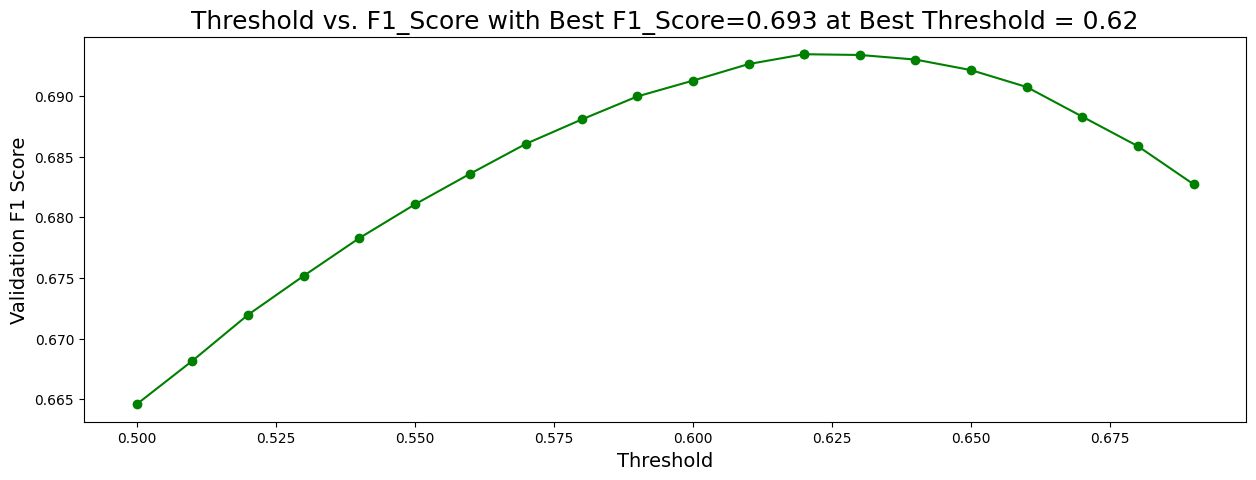

When using optimal threshold = 0.62...
Q0: F1 = 0.6647115230822992
Q1: F1 = 0.4966297565518459
Q2: F1 = 0.5038370594922319
Q3: F1 = 0.6662253635625636
Q4: F1 = 0.630928751336749
Q5: F1 = 0.6350185639348089
Q6: F1 = 0.616416720126357
Q7: F1 = 0.5614407639494928
Q8: F1 = 0.6241080587710209
Q9: F1 = 0.57704629856224
Q10: F1 = 0.6041119193563056
Q11: F1 = 0.5078174154740022
Q12: F1 = 0.4581873023648676
Q13: F1 = 0.6323558055918299
Q14: F1 = 0.592455879812832
Q15: F1 = 0.4800297978957445
Q16: F1 = 0.5459562582850029
Q17: F1 = 0.4880987963733634
==> Overall F1 = 0.6934633241653057
s


In [36]:
for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(15, 5))
plt.plot(thresholds, scores, '-o', color='green')
plt.scatter([best_threshold], [best_socre], color='green')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

In [37]:

importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

# Submission Jo Wilder

In [38]:
import jo_wilder_310 as jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [39]:
models_list = [[CatBoostClassifier().load_model(
    f"fold{fold}_q{q}.cbm"
) for fold in range(2)] for q in range(1, 19)]

In [40]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for test, sample_submission in iter_test:
    sample_submission['question'] = [int(label.split('_')[1][1:]) for label in sample_submission['session_id']]
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    a,b = limits[grp]    
        
    df = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    df = feature_engineer(df, grp, use_extra=True, feature_suffix='')
    df = time_feature(df)
    
    fold = 1
    preds = []
    a,b = limits[grp]
    
    for q in range(a, b):
        print("Question: ",q)
        FEATURES = importance_dict[str(q)]
        model = models_list[q-1][fold]
        
        pred = model.predict_proba(df[FEATURES].astype(np.float32))[:,1]
        mask = sample_submission.question == q 
        sample_submission.loc[mask, 'correct'] = (pred > best_threshold).astype('int') 

    env.predict(sample_submission[['session_id', 'correct']])

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18
Question:  1
Question:  2
Question:  3
Question:  4
Question:  5
Question:  6
Question:  7
Question:  8
Question:  9
Question:  10
Question:  11
Question:  12
Question:  13
Question:  14
Question:  15
Question:  16
Question:  17
Question:  18


In [41]:
sub = pd.read_csv('submission.csv')
print("Shape: ",sub.shape)
sub1 = sub[sub["session_id"].str.contains("session_id") == False]
print("Shape: ",sub1.shape)
sub1["correct"] = pd.to_numeric(sub1["correct"], downcast="float")
print("==> Test MEAN: ",np.mean(sub1["correct"]))
sub1.head(18)

Shape:  (54, 2)
Shape:  (54, 2)
==> Test MEAN:  0.6666667


,session_id,correct
0,20090109393214576_q1,1.0
1,20090109393214576_q2,1.0
2,20090109393214576_q3,1.0
3,20090109393214576_q4,1.0
4,20090109393214576_q5,0.0
5,20090109393214576_q6,1.0
6,20090109393214576_q7,1.0
7,20090109393214576_q8,0.0
8,20090109393214576_q9,1.0
9,20090109393214576_q10,0.0


In [42]:
def f(text: str,amount: float):
    print(text)
    print(type(amount))
    return text

f("hello","a")

hello
<class 'str'>


'hello'